<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/priors/lattice_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Insurance: Predicting Crash Risk for prospective customers

### Lattice based models

* allow you to actively encode domain knowledge into the learning process
* specify constraints such as monotonicity
* constraints are specified as lattices overlaying the learning process
* lattices are a way to specify constraints
* additional regularization can be added to the lattices
* domain knowledge to better extrapolate to the parts of the input space not covered by the training dataset
* avoid unexpected model behavior when the serving distribution is different from the training distribution

https://www.tensorflow.org/lattice
<br>
https://blog.tensorflow.org/2020/02/tensorflow-lattice-flexible-controlled-and-interpretable-ML.html
<br>
https://github.com/tensorflow/lattice


In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
# https://www.tensorflow.org/lattice/install

!pip install --upgrade tensorflow-lattice

     -------------------------------------- 236.6/236.6 KB 4.8 MB/s eta 0:00:00
     ------------------------------------- 254.5/254.5 KB 15.3 MB/s eta 0:00:00
     ---------------------------------------- 91.0/91.0 KB ? eta 0:00:00


In [ ]:
import neural_structured_learning as nsl

In [2]:
tf.random.set_seed(42)

In [3]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
import numpy as np
np.__version__

'1.21.6'

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [6]:
# !pip install -q dtreeviz

In [7]:
import dtreeviz
dtreeviz.__version__

ModuleNotFoundError: ignored

In [ ]:
# https://github.com/AndreasMadsen/python-lrcurve
# !pip install -q lrcurve

In [ ]:
from lrcurve import KerasLearningCurve

In [ ]:
from dtreeviz import clfviz

def plot_decision_boundaries(model, X, y_true, x1_range=None, x2_range=None):
    _, ax = plt.subplots(figsize=(8, 4), dpi=300)

    ranges = None
    if x1_range and x2_range:
        ranges = (x1_range, x2_range)

    clfviz(
        model, X, y_true,
        show=['instances', 'boundaries', 'probabilities', 'misclassified'],
        markers=['v', '^', 'd'],
        ntiles=50,
        ax=ax,
        ranges=ranges,
        tile_fraction=1.0,
        boundary_markersize=1.0,
        feature_names=["Age", "Max Speed"],
        colors={'class_boundary': 'black',
                'tile_alpha': 0.5,
                #  'warning' : 'yellow',
                'classes':
                [None,  # 0 classes
                 None,  # 1 class
                 None,  # 2 classes
                 ['#FF8080', '#FFFF80', '#8080FF'],  # 3 classes
                 ]
                }
    )

# Step 1: Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. Risk is expressed as a number between 0 and 1. 1 meaning highest and 0 meaning lowerst risk of having an accident.

In [8]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/djcordhose/ml-resources/master/notebooks/mlops/insurance-customers-risk-1500.csv')
df.head()

,speed,age,miles,group,risk
0,97.0,44.0,30.0,1,0.597611
1,135.0,63.0,29.0,1,0.452710
2,111.0,26.0,34.0,0,0.750234
3,97.0,25.0,10.0,1,0.325249
4,114.0,38.0,22.0,2,0.269731


In [9]:
df.describe()

,speed,age,miles,group,risk
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.323333,44.989333,30.384000,0.999333,0.505887
std,17.417147,17.145297,15.214166,0.817177,0.256517
min,80.000000,16.000000,1.000000,0.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000,0.319750
50%,120.000000,42.000000,29.000000,1.000000,0.502173
75%,137.000000,54.000000,42.000000,2.000000,0.685074
max,166.000000,100.000000,84.000000,2.000000,1.000000


In [10]:
features = ['speed', 'age', 'miles']

In [ ]:
import seaborn as sns

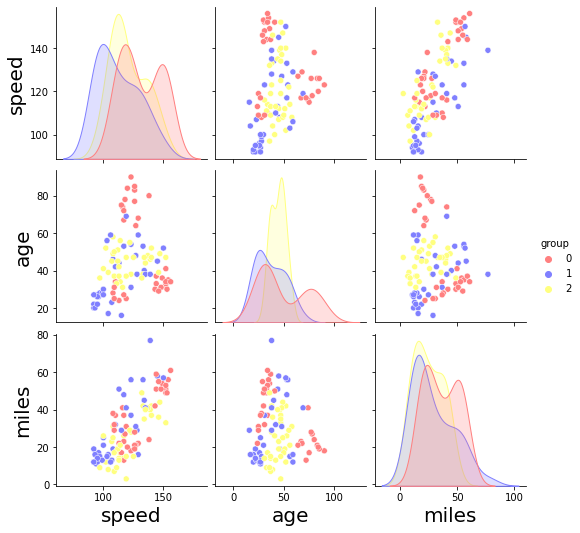

In [13]:
sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, hue="group", kind="scatter", diag_kind="kde", vars=features, palette={0: '#FF8080', 1: '#8080FF', 2: '#FFFF80'});

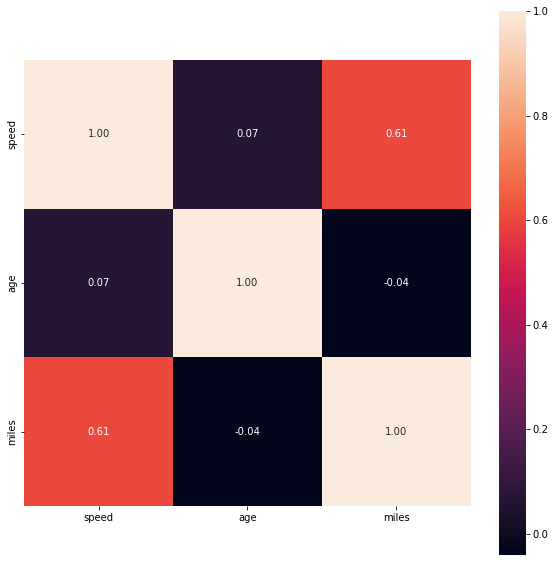

In [ ]:
plt.figure(figsize=(10, 10))

cm = df.corr()
cm3 = cm.iloc[:3, :3]

hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                yticklabels=features,
                xticklabels=features)

# Step 2: Training a neural network on 2 dimensions of the data

In [ ]:
y = df['group'].values
# add more columns to list to have fewer features to train on
X = df.drop(['risk', 'group', 'miles'], axis='columns').values
# reorder, first age, then speed to match plotting
X = pd.DataFrame(np.array([X[:, 1], X[:, 0]]).T)
X.shape, y.shape

((1500, 2), (1500,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 2), (300, 2), (1200,), (300,))

In [ ]:
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)

y_train = tf.expand_dims(tf.convert_to_tensor(y_train), axis=1)
y_val = tf.expand_dims(tf.convert_to_tensor(y_val), axis=1)

In [ ]:
X_train.shape, y_train.shape

(TensorShape([1200, 2]), TensorShape([1200, 1]))

In [ ]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.6
model = tf.keras.Sequential()

model.add(InputLayer(name='input', input_shape=(num_features,)))

model.add(Dense(500, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))
base_model = model

# Wrap the model with adversarial regularization.
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)

model = adv_model

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 500)               1500      
                                                                 
 activation (Activation)     (None, 500)               0         
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 hidden2 (Dense)             (None, 500)               250500    
                                                                 
 activation_1 (Activation)   (None, 500)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                        

In [ ]:
%%time 

BATCH_SIZE = 32
EPOCHS = 100

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit({'input': X_train, 'label': y_train},
                    validation_data={'input': X_val, 'label': y_val},
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


CPU times: total: 2min 42s
Wall time: 1min


In [ ]:
loss, scaled_adversarial_loss, accuracy, sparse_categorical_crossentropy = model.evaluate({'input': X_train, 'label': y_train}, batch_size=BATCH_SIZE)
accuracy

38/38 [==============================] - 0s 8ms/step - loss: 0.8199 - sparse_categorical_crossentropy: 0.6826 - sparse_categorical_accuracy: 0.7100 - scaled_adversarial_loss: 0.1373


0.7099999785423279

In [ ]:
loss, scaled_adversarial_loss, accuracy, sparse_categorical_crossentropy = model.evaluate({'input': X_val, 'label': y_val}, batch_size=BATCH_SIZE)
accuracy

10/10 [==============================] - 0s 7ms/step - loss: 0.8514 - sparse_categorical_crossentropy: 0.7088 - sparse_categorical_accuracy: 0.6900 - scaled_adversarial_loss: 0.1426


0.6899999976158142

In [ ]:
base_model.predict([[48, 100]])

array([[0.02572341, 0.11489787, 0.8593787 ]], dtype=float32)

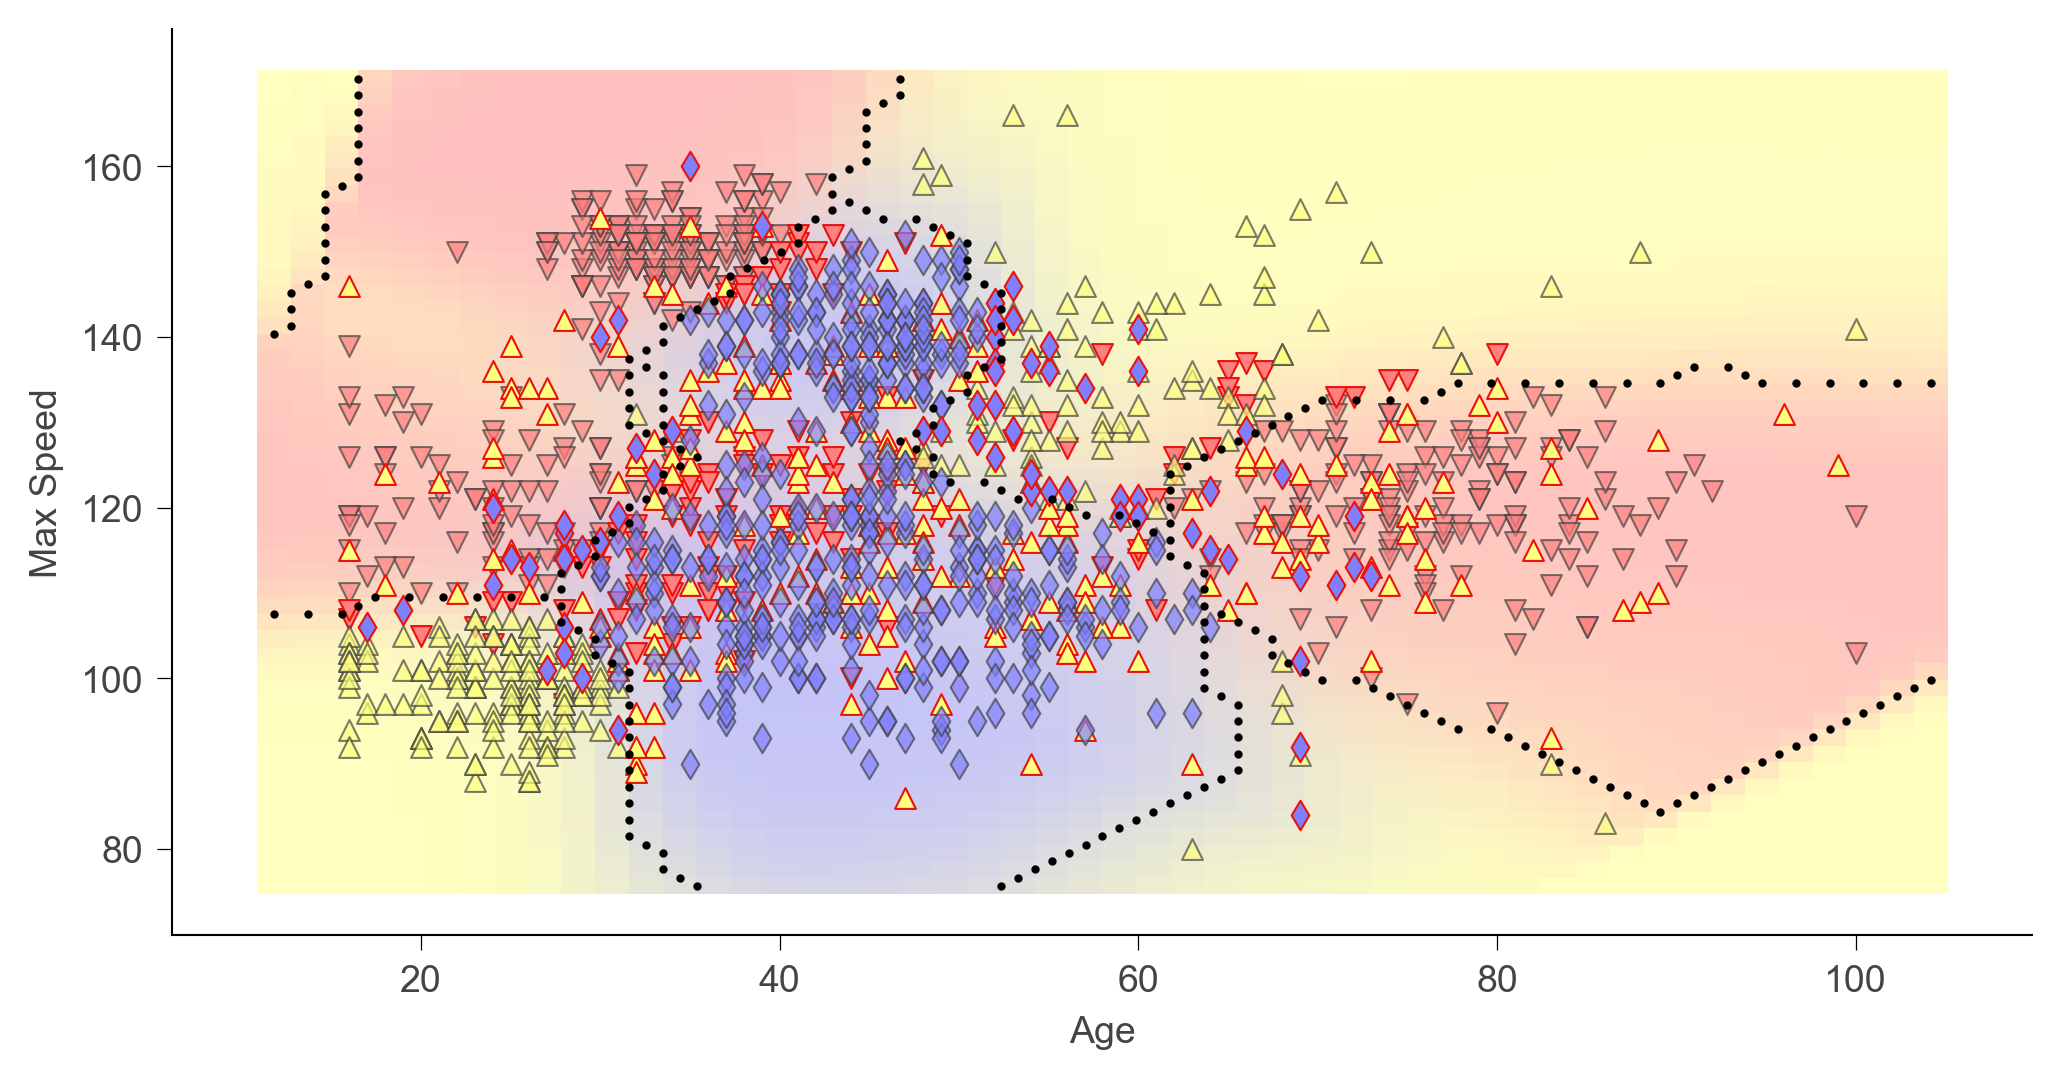

In [ ]:
plot_decision_boundaries(base_model, X, y)

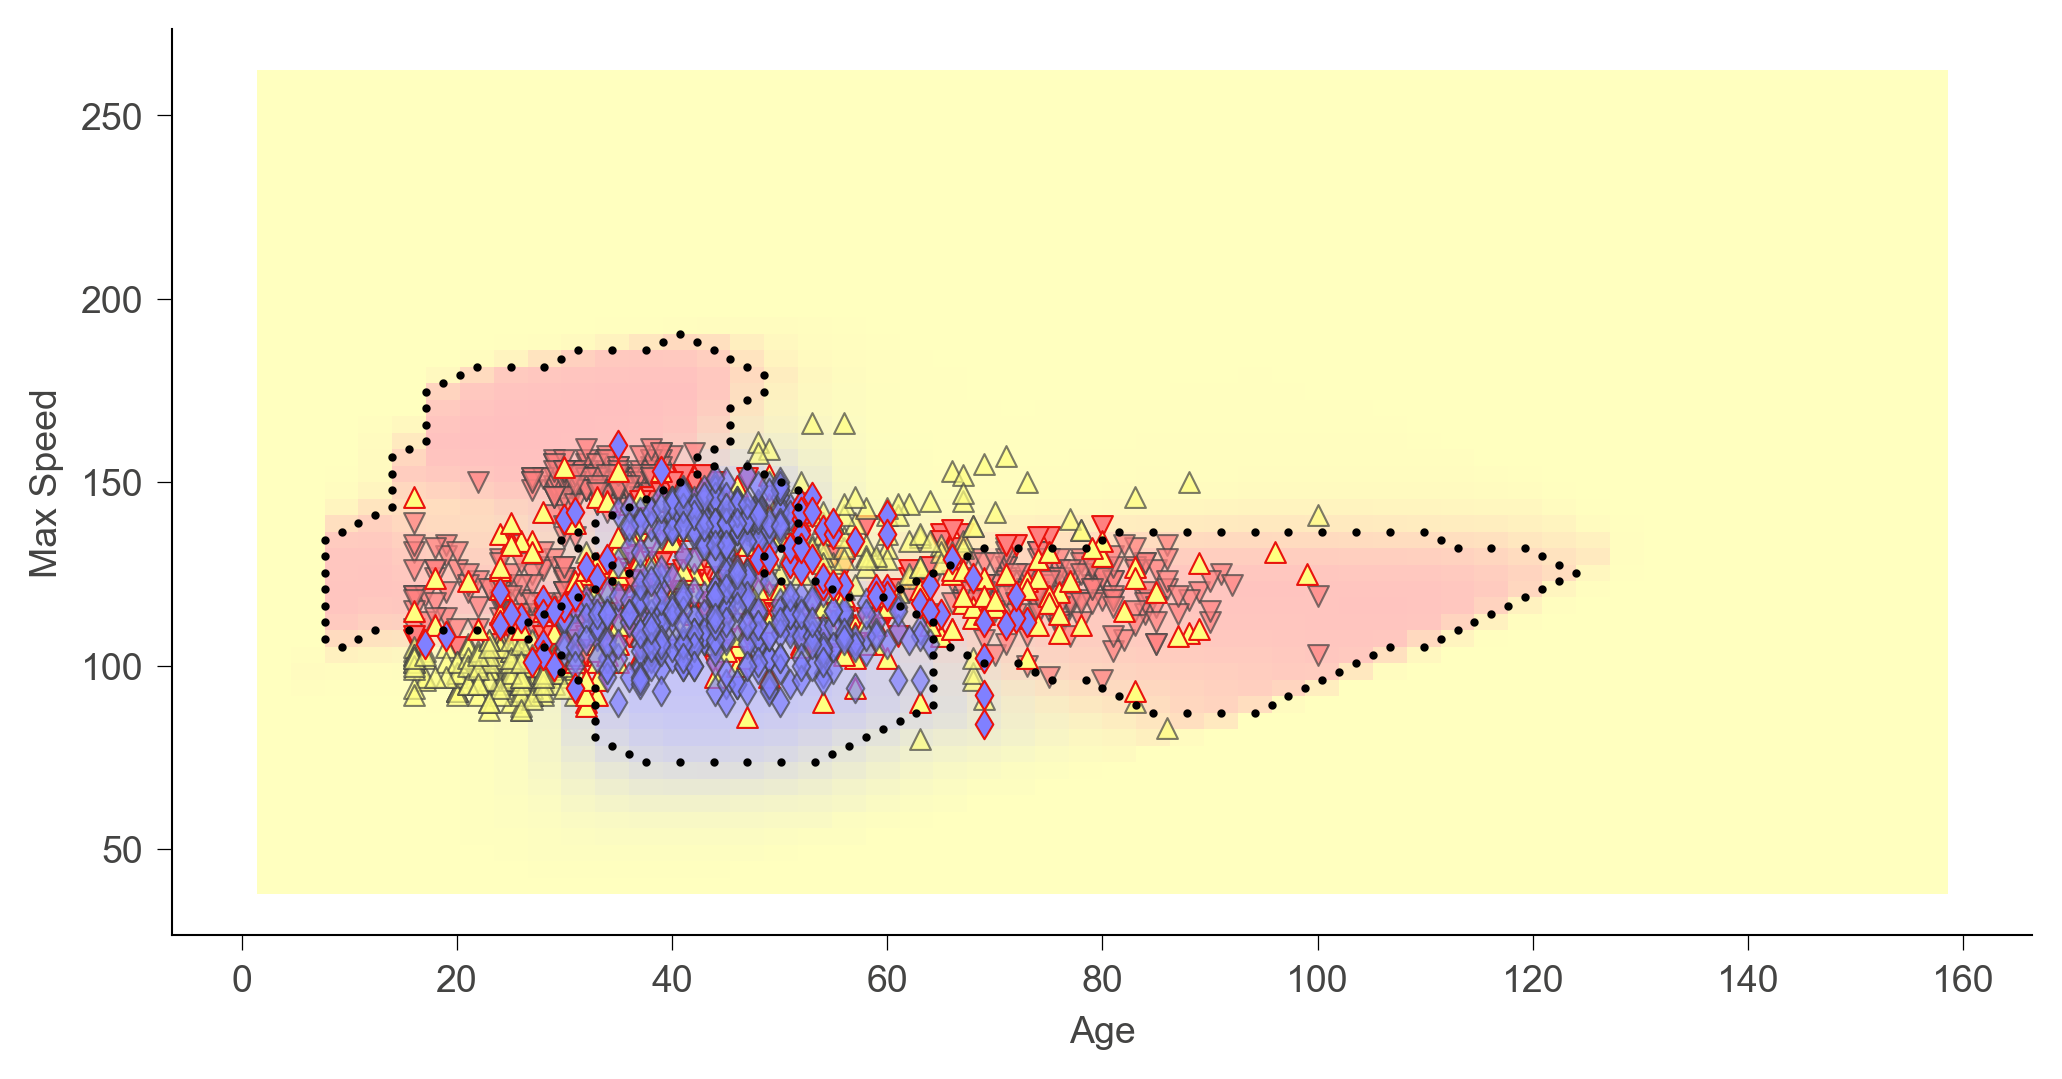

In [ ]:
plot_decision_boundaries(base_model, X, y, x1_range=(10, 150), x2_range=(50, 250))